### Re-defining TfL’s Strategic Neighbourhoods from the spatial and social perspectives
#### Code written by Xinlei Yan
# Notebook for creating the T-Communities

## 1. Load packages

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point

PROJ: proj_create_from_database: Cannot find proj.db


## 2. Read in data

### Read in pedestrian road data


In [2]:
road = gpd.read_file('data/road_4.shp')
road.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   OBJECTID_1  124011 non-null  int64   
 1   OBJECTID    124011 non-null  int64   
 2   FID_minor_  124011 non-null  int64   
 3   FID_outer0  124011 non-null  int64   
 4   Shape_Leng  124011 non-null  float64 
 5   ORIG_FID    124011 non-null  int64   
 6   Shape_Le_1  124011 non-null  float64 
 7   geometry    124011 non-null  geometry
dtypes: float64(2), geometry(1), int64(5)
memory usage: 7.6 MB


<AxesSubplot:>

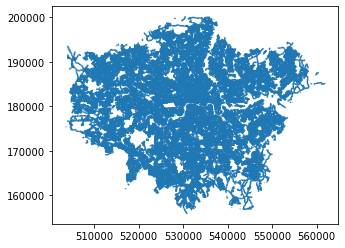

In [3]:
road.plot()

### Read in postcode data

In [4]:
postcode = gpd.read_file('data/postcode_2.shp')
postcode.insert(loc=2, column='group',value=0)
postcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 197843 entries, 0 to 197842
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   OBJECTID    197843 non-null  int64   
 1   FID_postco  197843 non-null  int64   
 2   group       197843 non-null  int64   
 3   POSTCODE    197843 non-null  object  
 4   UPP         197843 non-null  object  
 5   PC_AREA     197843 non-null  object  
 6   Shape_Leng  197843 non-null  float64 
 7   PCA1        197843 non-null  float64 
 8   PCA2        197843 non-null  float64 
 9   PCA3        197843 non-null  float64 
 10  PCA4        197843 non-null  float64 
 11  ID          197843 non-null  int64   
 12  FID_post_1  197843 non-null  int64   
 13  d_retail    197843 non-null  float64 
 14  d_transpor  197843 non-null  float64 
 15  D_public    197843 non-null  float64 
 16  D_attracti  197843 non-null  float64 
 17  bedroom     197843 non-null  float64 
 18  house_type  1978

## 3. Calculate the connected road network conponents for each sub-area

First analyse the connected components for all sub-areas

In [5]:
edge_all=gpd.GeoDataFrame()

for pid in range(0,1244):
    # interate through all 1244 sub-areas
    #print(pid)
    #here I print the number of the sub-area iterating to monitor the process
    road1=road.loc[road['FID_outer0'] == pid]
    #select the roads within the sub-area
    
    if (len(road1)!=0):
        G= nx.Graph()
        for i, line in road1.iterrows():            
            _l = list(line.geometry.coords)
            G.add_edges_from(list(zip(_l,_l[1:])))
        G.remove_edges_from(nx.selfloop_edges(G))
        components = nx.connected_components(G)
        components_num = nx.number_connected_components(G)
        #select the road networks within and acquire the connected components
        
        if(components_num>1):
            #if there are more than two connected components,create a list for the networks and each entry indicates one component

            for j in range(0,components_num):
                #iterate through all network components
                g1 = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[j])
                if(max(dict(nx.degree(g1)).values ())>2):                
                    df = nx.to_pandas_edgelist(g1)
                    edge_list = []

                    for k in range(0,len(df)):
                        edge_list.append({'geometry': LineString([df['source'][k], df['target'][k]])})

                    edge_gdf = gpd.GeoDataFrame(edge_list)
                    edge_gdf.crs = road.crs
                    edge_gdf['outer']=pid
                    edge_gdf['group']=j
                    
                    edge_all=edge_all.append(edge_gdf)

In [6]:
edge_all.crs = road.crs
edge_all.to_file('edge.shp')
# write the road network component

In [7]:
#network = edge_all
network = gpd.read_file('data/edge.shp') 
network.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    3263 non-null   int64   
 1   outer       3263 non-null   float64 
 2   group_      3263 non-null   float64 
 3   Shape_Leng  3263 non-null   float64 
 4   geometry    3263 non-null   geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 127.6 KB


In [8]:
#postcode = gpd.read_file('data/postcode_2.shp')
#postcode.insert(loc=2, column='group',value=0)
#postcode.info()

## 4. Calculate the T-Communities for each sub-area

In [9]:
for pid in range(0,1244):
    # interate through all 1244 sub-areas
    #print(pid)
    #here I print the number of the sub-area iterating to monitor the process
    
    postcode1=postcode.loc[postcode['FID_outer0'] == pid] #select the postcodes within the sub-area
    network1=network.loc[network['outer'] == pid] #select the connected components within the sub-area
    
    if (len(network1)>1):

        for i in range(0,len(postcode1)):
            # interate through all the postcodes in the sub-area
            s=postcode1['geometry'][postcode1.index[i]]
            distance=[]

            for j in range(0,len(network1)):               

                s2=network1['geometry'][network1.index[j]]
                distance.append(s.distance(s2))
                #calculate the distance from the postcode to all connectedcomponents

            postcode.loc[postcode1.index[i],'group']=distance.index(min(distance))
            #assign the postcode to the group of the closest component 


In [10]:
postcode.to_file('T-Communities.shp') 
#the postcodes need to be merged by their sub-area number and group number and furtherly processed to produce the final neighbourhood results